### Libraries

In [9]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

### Read from google drive

In [12]:
url = "https://drive.google.com/file/d/1YVppwFGtto12XLqDWos4xP-g2aXSqg8g/view?usp=sharing"
df = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url.split('/')[-2]), index_col=[0])
df.head(5)

,day,hour_interval,segmentId,speedLimit,frc,streetName,distance,harmonicAverageSpeed,medianSpeed,averageSpeed,standardDeviationSpeed,travelTimeStandardDeviation,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,lat1,lon1,lat2,lon2
0,MONDAY,00:00-02:00,-13600003425517,18,2,Jalan Trans Yogie,16.33,31.52,24.8,57.60,59.87,1.23,3,1.86,2.37,1.0,-6.37570,106.90701,-6.37555,106.90698
1,MONDAY,00:00-02:00,-13600001618936,50,5,Jalan Karya Bakti,34.33,28.10,28.1,28.10,0.00,0.00,1,4.40,4.40,1.0,-6.36841,106.89396,-6.36829,106.89368
2,MONDAY,00:00-02:00,-13600002440919,50,5,Jalan Karya Bakti,10.44,27.50,27.5,27.50,0.00,0.00,1,1.37,1.37,1.0,-6.36829,106.89368,-6.36825,106.89359
3,MONDAY,00:00-02:00,-13600001175418,50,5,Jalan Karya Bakti,284.25,27.60,27.6,27.60,0.00,0.00,1,37.08,37.08,1.0,-6.36825,106.89359,-6.36731,106.89120
4,MONDAY,00:00-02:00,-13600001957379,50,5,Jalan Karya Bakti,93.00,33.53,31.9,35.23,10.02,2.57,3,9.99,10.50,1.0,-6.36731,106.89120,-6.36700,106.89042


#### Filter

In [13]:

def change_day_to_num(x):
    dayDict = {
        'MONDAY': 0,
        'TUESDAY': 1, 
        'WEDNESDAY': 2,
        'THURSDAY': 3,
        'FRIDAY': 4,
        'SATURDAY': 5,
        'SUNDAY':6
    }

    return dayDict[x]

def encode_hour_interval(x):
    hourDict = {
        '00:00-02:00': 0,
        '02:00-04:00': 1,
        '04:00-06:00': 2,
        '06:00-08:00': 3,
        '08:00-10:00': 4,
        '10:00-12:00': 5,
        '12:00-14:00': 6,
        '14:00-16:00': 7,
        '16:00-18:00': 8,
        '18:00-20:00': 9,
        '20:00-22:00': 10,
        '22:00-23:59': 11
    }
    return hourDict.get(x, -1) 

def change_num_to_day(x):
    dayDict = {
        0: 'MONDAY', 
        1: 'TUESDAY', 
        2: 'WEDNESDAY', 
        3: 'THURSDAY', 
        4: 'FRIDAY', 
        5: 'SATURDAY', 
        6: 'SUNDAY'
    }

    return dayDict[x]
df['hourIntervalCode'] = df['hour_interval'].apply(encode_hour_interval)
df['dayCode'] = df['day'].apply(lambda x: change_day_to_num(x))

In [14]:
df.head()

,day,hour_interval,segmentId,speedLimit,frc,streetName,distance,harmonicAverageSpeed,medianSpeed,averageSpeed,...,sampleSize,averageTravelTime,medianTravelTime,travelTimeRatio,lat1,lon1,lat2,lon2,hourIntervalCode,dayCode
0,MONDAY,00:00-02:00,-13600003425517,18,2,Jalan Trans Yogie,16.33,31.52,24.8,57.60,...,3,1.86,2.37,1.0,-6.37570,106.90701,-6.37555,106.90698,0,0
1,MONDAY,00:00-02:00,-13600001618936,50,5,Jalan Karya Bakti,34.33,28.10,28.1,28.10,...,1,4.40,4.40,1.0,-6.36841,106.89396,-6.36829,106.89368,0,0
2,MONDAY,00:00-02:00,-13600002440919,50,5,Jalan Karya Bakti,10.44,27.50,27.5,27.50,...,1,1.37,1.37,1.0,-6.36829,106.89368,-6.36825,106.89359,0,0
3,MONDAY,00:00-02:00,-13600001175418,50,5,Jalan Karya Bakti,284.25,27.60,27.6,27.60,...,1,37.08,37.08,1.0,-6.36825,106.89359,-6.36731,106.89120,0,0
4,MONDAY,00:00-02:00,-13600001957379,50,5,Jalan Karya Bakti,93.00,33.53,31.9,35.23,...,3,9.99,10.50,1.0,-6.36731,106.89120,-6.36700,106.89042,0,0


In [15]:
df.shape

(11396536, 22)

#### Adding Travel Time Index Feature

In [ ]:
# calculate travel time index
def calculate_tti(avgTravelTime, distance, speedLimit):
    # average travel time free-flow congestion
    avgTravelTimeFC = distance/speedLimit

    return avgTravelTime/avgTravelTimeFC

df['travelTimeIndex'] = df['averageTravelTime'] / (df['distance'] / (df['speedLimit'] * 1000 / 3600))

### EDA

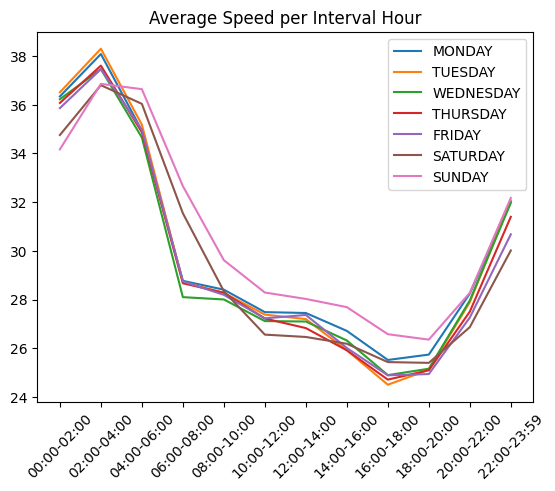

In [ ]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df[df['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageSpeed'].mean()
    
    plt.plot(hour_interval_list_day, avg_speed_per_interval_hour_day, label=day_name)
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f"Average Speed per Interval Hour")

plt.show()

1. Secara keseluruhan, setiap jalan di Jakarta memang sering mengalami kemacetan untuk tiap jamnya. Hal ini dapat dilihat dari interval tengah malam (0:00 - 2:00) yang rata-rata kecepatannya di bawah 40 .../...

2. Dari semua interval jam, kecepatan terendah berada pada kisaran jam 16.00-18.00 pada hari Selasa

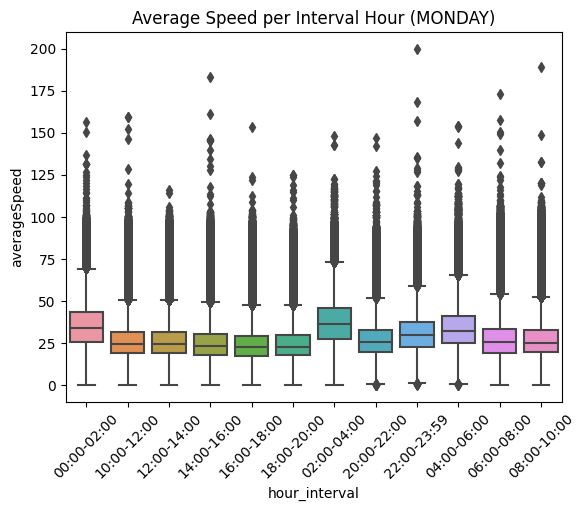

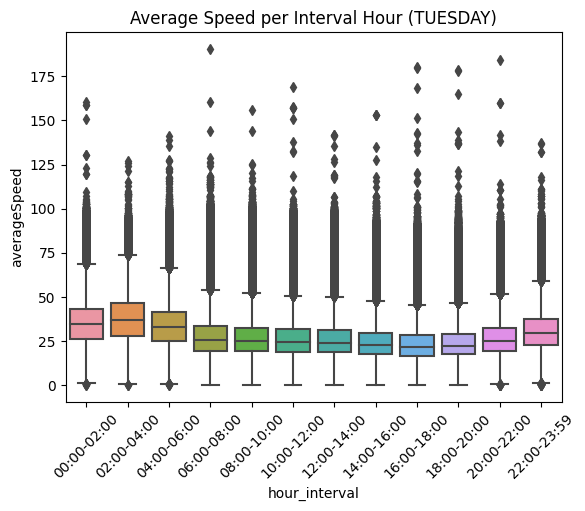

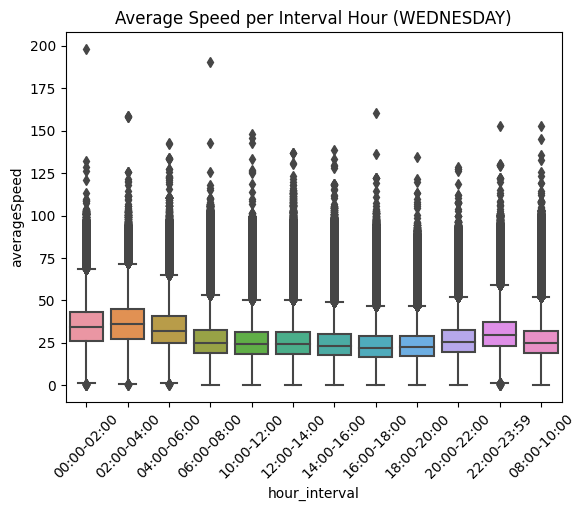

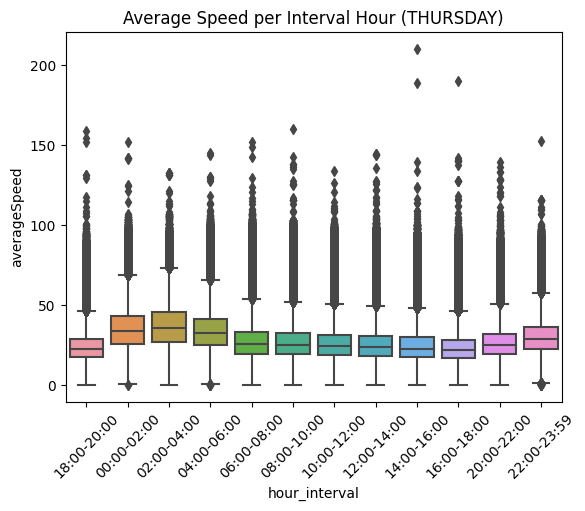

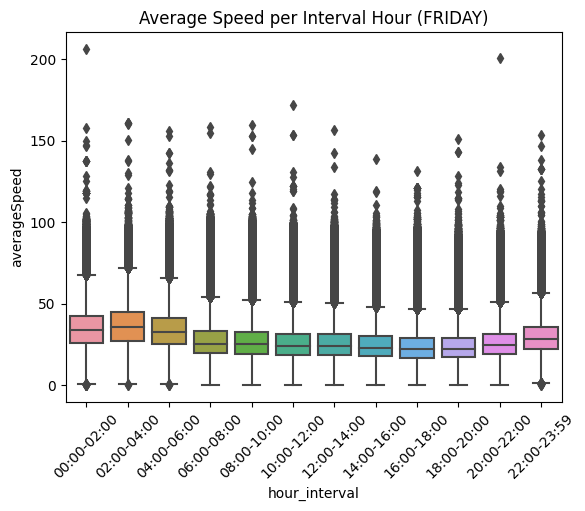

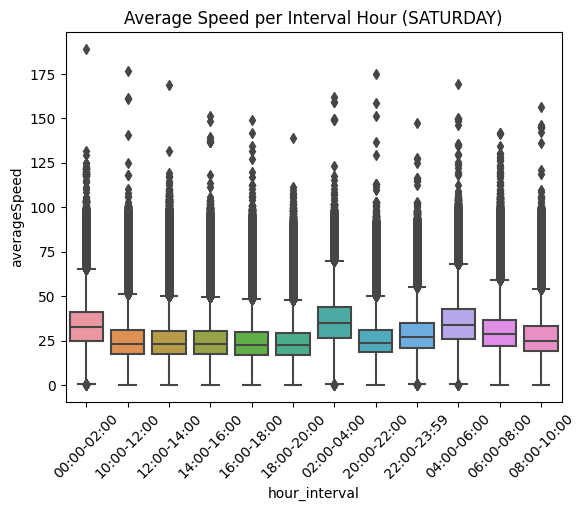

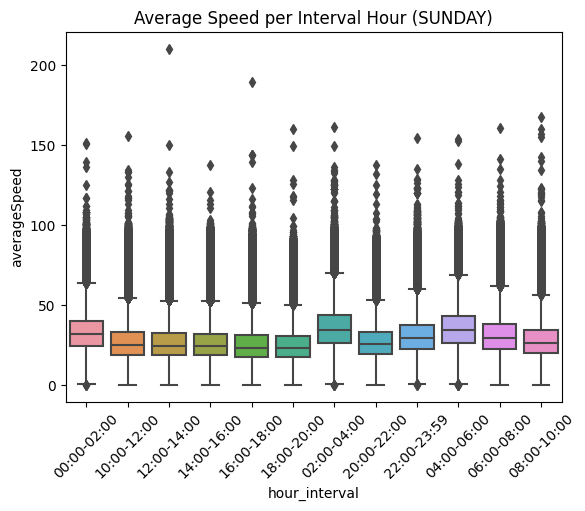

In [ ]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df[df['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageSpeed']

    sns.boxplot(data=daySeries, x='hour_interval', y='averageSpeed')
    
    plt.xticks(rotation=45)
    plt.title(f"Average Speed per Interval Hour ({day_name})")

    plt.show()

Pada pencilan, dapat terlihat bahwa terdapat jalan tertentu di mana dapat menghasilkan kecepatan kendaraan yang sangat tinggi. Hal ini berarti bahwa ada kemungkinan besar terdapat jalan-jalan tertentu di waktu tertentu yang tidak sering mengalami kemacetan.

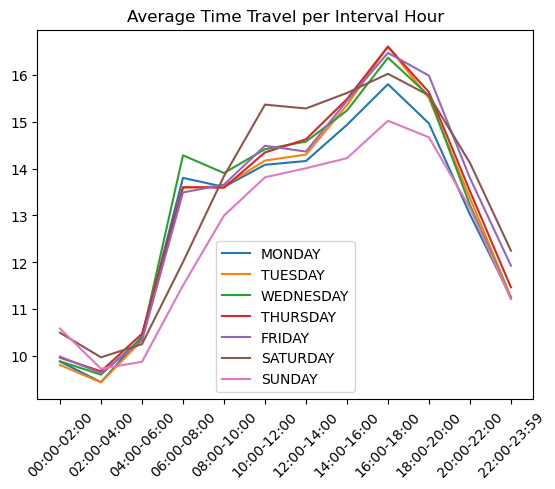

In [ ]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df_eda[df_eda['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageTravelTime'].mean()
    
    plt.plot(hour_interval_list_day, avg_speed_per_interval_hour_day, label=day_name)
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f"Average Time Travel per Interval Hour")

plt.show()

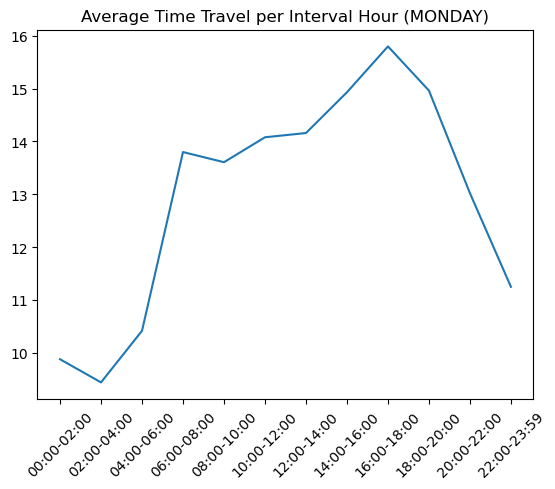

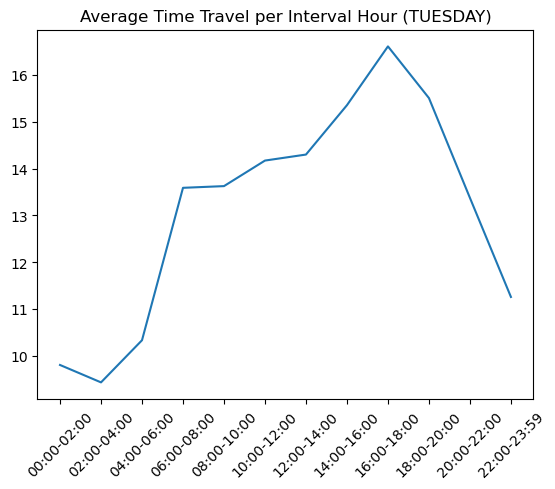

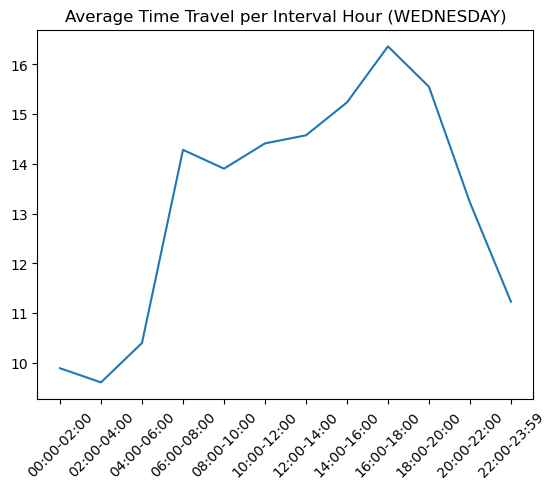

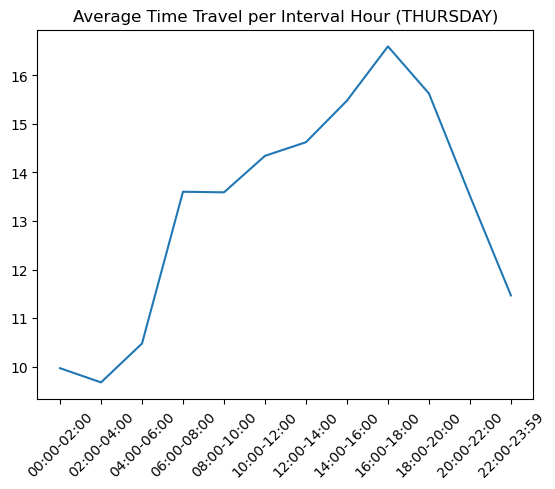

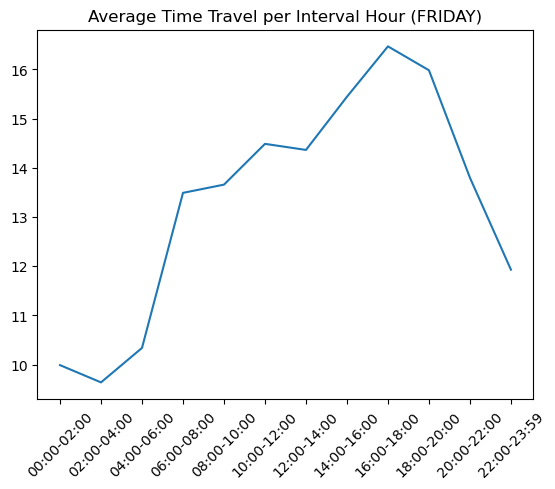

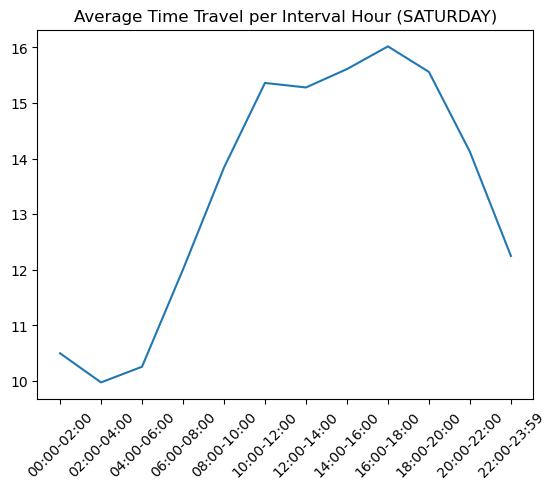

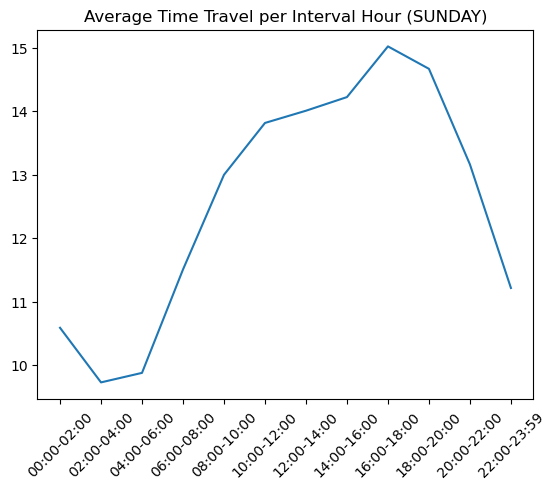

In [ ]:
for i in range(7):
    day_name = change_num_to_day(i)
    daySeries = df_eda[df_eda['dayCode'] == i].copy()

    hour_interval_list_day = sorted(daySeries['hour_interval'].unique())
    avg_speed_per_interval_hour_day = daySeries.groupby(['hour_interval'], sort=True)['averageTravelTime'].mean()
    
    plt.plot(hour_interval_list_day, avg_speed_per_interval_hour_day, label=day_name)
    plt.xticks(rotation=45)
    plt.title(f"Average Time Travel per Interval Hour ({day_name})")

    plt.show()

In [ ]:
no_congestion_df = df[df['travelTimeIndex'] <= 1.2]
with_congestion_df = df[df['travelTimeIndex'] > 1.2]

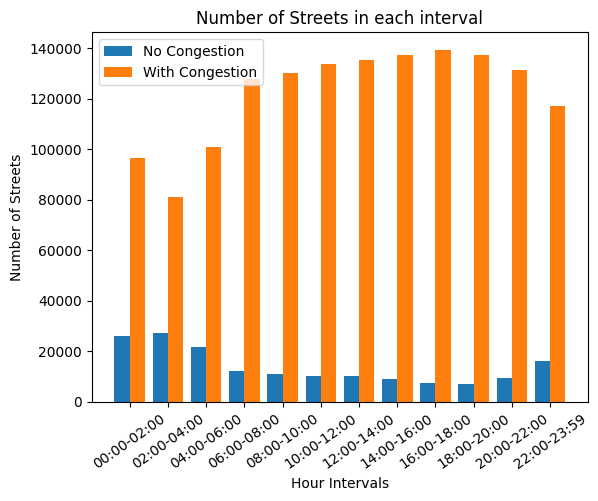

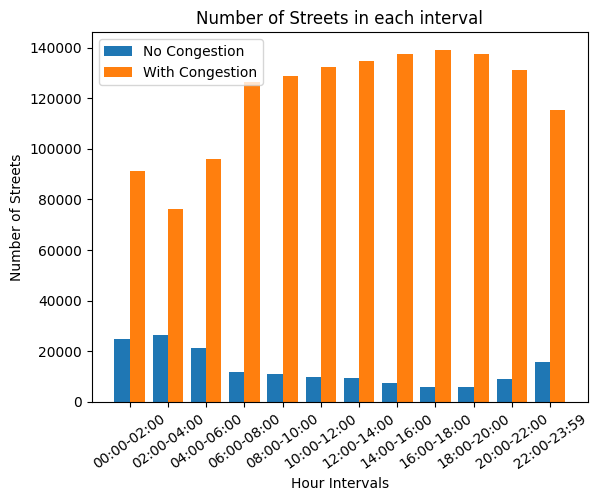

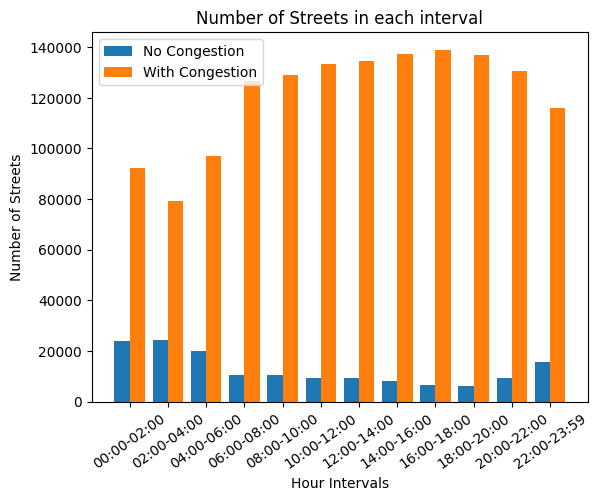

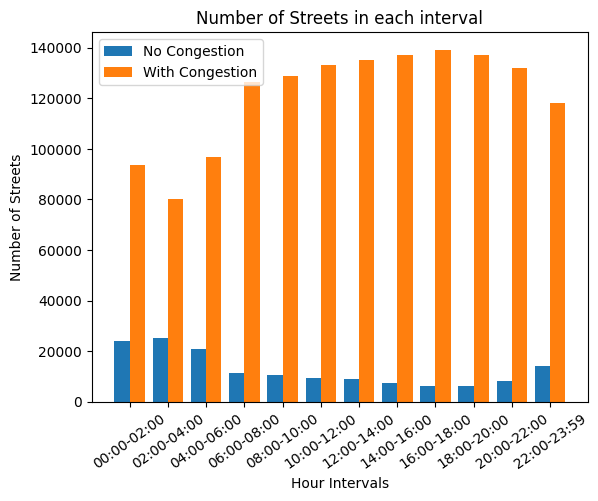

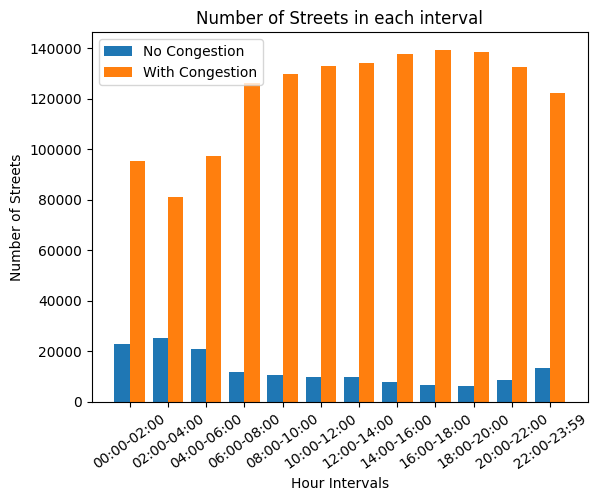

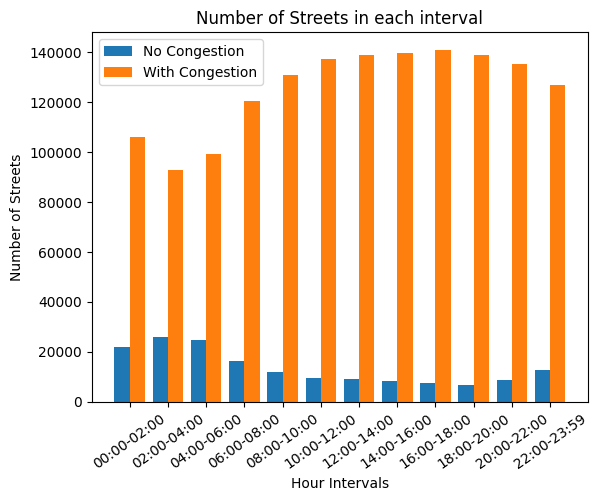

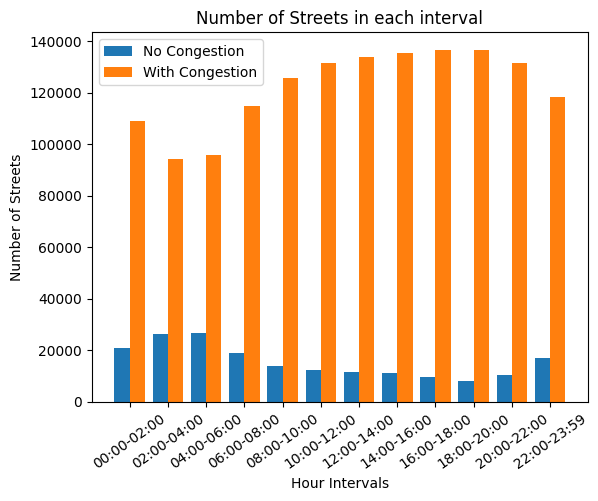

In [ ]:
import numpy as np

for i in range(7):
    nc_daySeries = no_congestion_df[no_congestion_df['dayCode'] == i]
    wc_daySeries = with_congestion_df[with_congestion_df['dayCode'] == i]

    hour_interval_list = sorted(nc_daySeries['hour_interval'].unique())

    nc_list = []
    wc_list = []

    X_axis = np.arange(len(hour_interval_list))
    for j in hour_interval_list:
        nc_count = len(nc_daySeries[nc_daySeries['hour_interval'] == j])
        wc_count = len(wc_daySeries[wc_daySeries['hour_interval'] == j])

        nc_list.append(nc_count)
        wc_list.append(wc_count)
    
    plt.bar(X_axis - 0.2, nc_list, 0.4, label = 'No Congestion') 
    plt.bar(X_axis + 0.2, wc_list, 0.4, label = 'With Congestion') 
    
    plt.xticks(X_axis, hour_interval_list, rotation=35) 
    plt.xlabel("Hour Intervals") 
    plt.ylabel("Number of Streets") 
    plt.title("Number of Streets in each interval") 
    plt.legend() 
    plt.show() 

#### EDA Map

In [ ]:
df_eda_monday_10_12 = df[(df['day'] == 'MONDAY') & (df['hour_interval'] == '10:00-12:00')]

In [ ]:
import folium

# Sample data
map_jakarta = folium.Map(location=[-6.2, 106.85], zoom_start=12)

# Function to add lines to the map
def add_lines_to_map(df_eda_monday_10_12, map_object):
    for _, row in df_eda_monday_10_12.iterrows():
        if row['travelTimeIndex'] < 1.3:
            color = 'green' 
        elif row['travelTimeIndex'] < 2:
            color = 'orange'
        else: 
            color = 'red'
        folium.PolyLine(
            locations=[(row['lat1'], row['lon1']), (row['lat2'], row['lon2'])],
            color=color,
            weight=5
        ).add_to(map_object)

# Add lines to the map
add_lines_to_map(df_eda_monday_10_12, map_jakarta)

# Save the map to an HTML file
map_jakarta.save('jakarta_traffic_oct_monday_10-12.html')


#### Heatmap

In [ ]:
values = df_eda_monday_10_12['averageTravelTime']

arr_daily = values.values.copy()
arr_daily.resize(7, 12)

ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(np.transpose(arr_daily), linewidths=1, cmap='coolwarm')

yticks_labels = sorted(gdrive_df['hour_interval'].unique())
xticks_labels = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']

plt.yticks(np.arange(12) + .5, labels=yticks_labels, rotation=0)
plt.xticks(np.arange(7) + .5, labels=xticks_labels)
plt.title("Traffic over the day")
plt.show()

### Model

In [ ]:
features = df.drop([
    'streetName', 'segmentId', 'sampleSize', 
    'averageTravelTime','travelTimeStandardDeviation', 
    'medianTravelTime', 'travelTimeRatio', 'day', 'hour_interval'], axis=1)  
target = df['averageTravelTime']

In [ ]:
features.columns

Index(['speedLimit', 'frc', 'distance', 'harmonicAverageSpeed', 'medianSpeed',
       'averageSpeed', 'standardDeviationSpeed', 'lat1', 'lon1', 'lat2',
       'lon2', 'hourIntervalCode', 'dayCode', 'travelTimeIndex'],
      dtype='object')

In [ ]:
scorers = {
    'r2': make_scorer(r2_score),
    'rmse': make_scorer(mean_squared_error, squared=False),  # RMSE
    'mae': make_scorer(mean_absolute_error)
}

#### Linear Regression

In [ ]:
lr_model = LinearRegression()

In [ ]:
lr_scores =cross_validate(lr_model, features, target, cv=5, scoring=scorers, return_train_score=False)

# Output the cross-validation lr_scores
print(f"r2 : {np.mean(lr_scores['test_r2'])}")
print(f"rmse: {np.mean(lr_scores['test_rmse'])}")
print(f"mae: {np.mean(lr_scores['test_mae'])}")

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: '

r2 : 0.7224157988878305
rmse: 8.670980386994682
mae: 4.063014617189731


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
lr_model.fit(features, target)
coefficients = lr_model.coef_
feature_importances = pd.DataFrame(coefficients, index=features.columns, columns=['importance'])

# Sort feature importances
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Display the feature importances
print(feature_importances)

                        importance
lat2                     31.320311
lon2                      1.895357
travelTimeIndex           1.194136
distance                  0.116791
standardDeviationSpeed    0.058451
medianSpeed               0.026256
hourIntervalCode          0.013405
frc                      -0.008069
dayCode                  -0.010568
speedLimit               -0.014036
harmonicAverageSpeed     -0.130013
averageSpeed             -0.165882
lon1                     -2.475681
lat1                    -34.101853


#### KNN


In [ ]:
knn_model = KNeighborsRegressor()
knn_scores =cross_validate(knn_model, features, target, cv=5, scoring=scorers, return_train_score=False)

# Output the cross-validation knn_scores
print(f"r2 : {np.mean(knn_scores['test_r2'])}")
print(f"rmse: {np.mean(knn_scores['test_rmse'])}")
print(f"mae: {np.mean(knn_scores['test_mae'])}")

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: '

r2 : 0.9869362508538805
rmse: 1.8272480294512718
mae: 0.27383018852122637


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### LightGBM

In [ ]:
lgbm_model = LGBMRegressor()
lgbm_scores =cross_validate(lgbm_model, features, target, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)

# Output the cross-validation lgbm_scores
print(f"r2 : {np.mean(lgbm_scores['test_r2'])}")
print(f"rmse: {np.mean(lgbm_scores['test_rmse'])}")
print(f"mae: {np.mean(lgbm_scores['test_mae'])}")

r2 : 0.9811336237712357
rmse: 2.2459750525341957
mae: 0.3733099357747879
